# CENG796 Term Project

## HoloGAN: Unsupervised Learning of 3D Representations from Natural Images

Our term project is to re-implementation of the HoloGAN: Unsupervised Learning of 3D Representations from Natural Images [paper](https://arxiv.org/abs/1904.01326). The original Tensorflow implementation of HoloGAN can be found in [the GitHub repo](https://github.com/thunguyenphuoc/HoloGAN) of the authors.

### Abstract of the paper

We propose a novel generative adversarial network (GAN) for the task of unsupervised learning of 3D representations from natural images. Most generative models rely on 2D kernels to generate images and make few assumptions about the 3D world. These models therefore tend to create blurry images or artefacts in tasks that require a strong 3D understanding, such as novel-view  synthesis. HoloGAN instead learns a 3D representation of the world, and to render this representation in a realistic manner. Unlike other GANs, HoloGAN provides explicit control over the pose of generated objects through rigid-body transformations of the learnt 3D features. Our experiments show that using explicit 3D features enables HoloGAN to disentangle 3D pose and identity, which is further decomposed into shape and appearance, while still being able to generate images with similar or higher visual quality than other generative models. HoloGAN can be trained end-to-end from unlabelled 2D images only. Particularly, we do not require pose labels, 3D shapes, or multiple views of the same objects. This shows that HoloGAN is the first generative model that learns 3D representations from natural images in an entirely unsupervised manner.


In [13]:
from IPython.display import HTML
HTML('<img src="figures/hologan.PNG" width="900">')

In [15]:
from IPython.display import HTML
HTML('<img src="figures/generator.PNG">')

"Since the training images are captured with different perspectives, HoloGAN needs to learn perspective projection. However, as we have no knowledge of the camera intrinsics, we employ two layers of 3D convolutions (without AdaIN) to morph the 3D representation into a perspective frustum (see Figure 3) before their projection to 2D features." (taken from HoloGAN paper).


### Group members of the project

Edanur Demir and Gökhan Özsarı

### Project

We have re-implemented the HoloGAN in PyTorch. Our source codes, license.txt, download_data.sh script can be found in [the GitHub repo](https://github.com/eksuas/HoloGAN-PyTorch). We prepared two download_data scripts as a bash and a python script. You may choose either one according to your desire.

### Hyper-parameters

These are the hyper-parameters of our model:

```
  --seed N              random seed
  --image-path S        training dataset directory path (default: '../dataset/celebA/')
  --dataset {celebA}    dataset selection (default: celebA)
  --gpu                 flag to enable cuda computation (default: False)
  --batch-size N        training batch size of the model (default: 32)
  --max-epochs N        the maximum number of epochs for training (default: 50)
  --epoch-step N        epoch step to compute the adaptive learning rate (default: 25)
  --z-dim N             the length of the generative model input (default: 128)
  --d-lr N              the learning rate of the discriminator (default: 0.0001)
  --g-lr N              the learning rate of the generator (default: 0.0001)
  --beta1 N             minimum betas parameter of the Adam optimizer (default: 0.5)
  --beta2 N             maximum betas parameter of the Adam optimizer (default: 0.999)
  --lambda-latent N     the lambda latent coefficient given in the paper (default: 0.0)
  --elevation-low N     the minimum elevation angle (default: 70)
  --elevation-high N    the maximum elevation angle (default: 110)
  --azimuth-low N       the minimum azimuth angle (default: 220)
  --azimuth-high N      the maximum azimuth angle (default: 320)
  --scale-low N         the minimum scaling value of 3D transformation (default: 1.0)
  --scale-high N        the maximum scaling value of 3D transformation (default: 1.0)
  --transX-low N        the minimum translation factor across the X-axis (default: 0)
  --transX-high N       the maximum translation factor across the X-axis (default: 0)
  --transY-low N        the minimum translation factor across the Y-axis (default: 0)
  --transY-high N       the maximum translation factor across the Y-axis (default: 0)
  --transZ-low N        the minimum translation factor across the Z-axis (default: 0)
  --transZ-high N       the maximum translation factor across the Z-axis (default: 0)
  --log-interval N      logging interval in terms of batch size (default: 1000)
  --update-g-every-d N  do not save the current model
  --no-save-model       flag to not save the current model (default: False)
  --rotate-elevation    flag to rotate the z sampling with elevation (default: False)
  --rotate-azimuth      flag to rotate the z sampling with azimuth (default: False)
  --load-dis S          the path for loading and/or evaluating the discriminator
  --load-gen S          the path for loading and/or evaluating the generator
```

### Creating a Model

An instance of the HoloGAN model can be created by giving the arguments as a parameter as below. Generated samples, training loss values and saved models of each epoch can be found in the "samples", "results" and "models" folders, respectively. Because we keep track of the model at each epoch, broken training can be detected easily and training will continue from where it left off. In this case, we can see the starting epochs as given below.

In [1]:
import sys
from init import initializer
from hologan import HoloGAN

sys.argv = ["", "--max-epochs", "3"]
args = initializer()
model = HoloGAN(args)

### Training

The HoloGAN model has its own training function as below. During training, it updates the parameters of the Discriminator at each batch one time. But, the Generator is updated two times at each batch. Details can be found in discriminator.py and generator.py

In [2]:
def train(self, args):
    """HoloGAN trainer

    This method train the HoloGAN model.
    """
    d_lr = args.d_lr
    g_lr = args.g_lr
    for epoch in range(args.start_epoch, args.max_epochs):
        # Adaptive learning rate
        if epoch >= args.epoch_step:
            adaptive_lr = (args.max_epochs - epoch) / (args.max_epochs - args.epoch_step)
            d_lr *= adaptive_lr
            g_lr *= adaptive_lr
            for param_group in self.optimizer_discriminator.param_groups:
                param_group['lr'] = d_lr
            for param_group in self.optimizer_generator.param_groups:
                param_group['lr'] = g_lr

        result = collections.OrderedDict({"epoch":epoch})
        result.update(self.train_epoch(args, epoch))
        # validate and keep history at each log interval
        self.save_history(args, result)

    # save the model giving the best validation results as a final model
    if not args.no_save_model:
        self.save_model(args, args.max_epochs-1, best=True)
        
model.train(args)

Epoch: [ 2] [  0/  2] time: 38.17sec, d_loss: 0.0540, g_loss: 6.4403, q_loss: 0.3702
Epoch: [ 2] [  1/  2] time: 3.17sec, d_loss: 0.0060, g_loss: 6.6410, q_loss: 0.3720


### Saving and Loading

All trained models are saved in default. If saving is not desired, --no-save-model flag should be enabled.

Pre-trained models can be loaded as given below. We have trained our model on Tesla P100 and Quadro GV100 machines. These trained models were saved. In order to load and take samples from these models, --gpu flag should be enabled as given below. 


In [2]:
import sys
from init import initializer
from hologan import HoloGAN

sys.argv = ["", "--rotate-azimuth", "--gpu", "--batch-size", "1",
            "--load-dis", "models/model_final/discriminator.pt",
            "--load-gen", "models/model_final/generator.pt"]
args = initializer()
model = HoloGAN(args)

### Sampling

The model generates samples via sample method. It takes initial arguments and boolean "trained" and "collection" flags. "trained" flags indicate the model is already trained and will be used just to generate samples. In this case, the generated samples are saved under the timestamp folder. Otherwise, they are saved under the folder named with the current epoch number. The "collection" flag is used to specify whether the resulting samples will be single images or a collage of images. The generated images are saved under the specified folders as shown below.


In [4]:
model.sample(args, trained=True, collection=True)

Samples are saved in samples\celebA\sample_1590336202.240141\samples_220.png
Samples are saved in samples\celebA\sample_1590336202.240141\samples_230.png
Samples are saved in samples\celebA\sample_1590336202.240141\samples_240.png
Samples are saved in samples\celebA\sample_1590336202.240141\samples_250.png
Samples are saved in samples\celebA\sample_1590336202.240141\samples_260.png
Samples are saved in samples\celebA\sample_1590336202.240141\samples_270.png
Samples are saved in samples\celebA\sample_1590336202.240141\samples_280.png
Samples are saved in samples\celebA\sample_1590336202.240141\samples_290.png
Samples are saved in samples\celebA\sample_1590336202.240141\samples_300.png
Samples are saved in samples\celebA\sample_1590336202.240141\samples_310.png


### Qualitative Results

We plan to generate the CelebA samples given in the Figure-5 in the paper. These are 64x64 samples in the task of separating identity and azimuth rotation (from the degree of 220 to 310). 

In [21]:
from IPython.display import HTML
HTML('<img src="figures/goal.PNG" width="900">')

We have trained our version-1 model with 100 epochs and our default hyper-parameters. Our samples are shown below so that they can be compared with the samples of the paper.

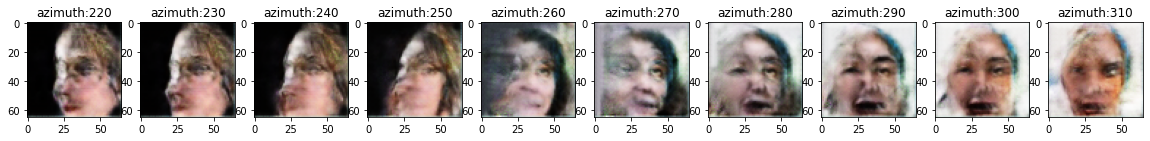

In [8]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

if args.rotate_azimuth:
    low, high, step = args.azimuth_low, args.azimuth_high, 10
elif args.rotate_elevation:
    low, high, step = args.elevation_low, args.elevation_high, 5
else:
    low, high, step = 0, 10, 1

timestamp = "1590336202.240141" # The samples generated above
folder = os.path.join(args.samples_dir, "sample_"+str(timestamp))

fig = plt.figure(figsize=(20,20))
for i, rotation in enumerate(range(low, high, step)):
    image = mpimg.imread(os.path.join(folder, "samples_"+str(rotation)+".png"))
    a = fig.add_subplot(1, 10, i+1)
    plt.imshow(image)
    a.set_title("azimuth:" + str(rotation))

plt.show()

We have trained our final model with 32 epochs and our default hyper-parameters. Our samples are shown below so that they can be compared with the samples of the paper.

As seen from the results, our samples were not successful as given in the paper. We had a strong mode collapse and bad visual quality. 

The following gif shows the resulting samples from the first epoch. The rotation effects can be seen clearly by changing the azimuth rotation. By enabling the --rotate-azimuth flag, code generates the samples in different rotations (from the degree of 220 to 310) as given below.

In [12]:
from IPython.display import HTML
HTML('<img src="samples/epoch0.gif">')

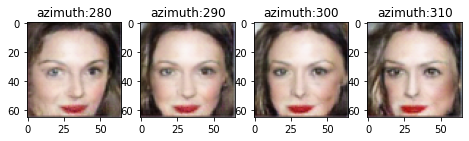

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

if args.rotate_azimuth:
    low, high, step = args.azimuth_low, args.azimuth_high, 10
elif args.rotate_elevation:
    low, high, step = args.elevation_low, args.elevation_high, 5
else:
    low, high, step = 0, 10, 1

timestamp = "1591872299.215277" # The samples generated above
folder = os.path.join(args.samples_dir, "sample_"+str(timestamp))

fig = plt.figure(figsize=(20,20))
for i, rotation in enumerate(range(280, high, step)):
    image = mpimg.imread(os.path.join(folder, "samples_"+str(rotation)+".png"))
    a = fig.add_subplot(1, 10, i+1)
    plt.imshow(image)
    a.set_title("azimuth:" + str(rotation))

plt.show()

In [6]:
from IPython.display import HTML
HTML('<img src="samples/epoch32.gif">')

### Quantitative Results

Our goal is to obtain the KID scores given in the Table-1 in the paper. The original model gets a 2.87 $\pm$ 0.09 KID score with CelebA dataset. Note that the KID score indicated the difference between real images and the generated samples (lower is better). 


In [22]:
from IPython.display import HTML
HTML('<img src="figures/goal_table.PNG" width="500">')

In order to compute out KID score, we use the source code in [the GitHub repo](https://github.com/abdulfatir/gan-metrics-pytorch) of Abdul Fatir by modifying it a little bit (e.g. changing file path and randomizing). Because we use additional source code, we don't share these codes with our version-1 package.

Our KID score between all images in the dataset and our final 10 samples (a sample for each rotation) is 4.58 $\pm$ 0.04. It is worse than the original study. We expect these results because the visual quality of our samples are worse than the original study, as well. But, note that the HoloGAN is not successful in KID score with CelebA dataset. In the paper, the HoloGAN also gives the worst KID score according to the baseline.


### Difficulties Encountered

The paper defines and explains the model in a clear way. The authors shares their source code in [the GitHub repo](https://github.com/thunguyenphuoc/HoloGAN) and [the supplemental document](http://openaccess.thecvf.com/content_ICCV_2019/supplemental/Nguyen-Phuoc_HoloGAN_Unsupervised_Learning_ICCV_2019_supplemental.pdf) to explain the model in detail, as well. However, most of the details about the training configuration such as learning rate, the number of epochs, batch size and updating interval of the generator (e.g. updating the generator every 5 epochs) are not shared. We examined their source code to find a clue on these issues. We have followed the default values of their source code so that we trained our model with 50 epochs, 32 batch size. In addition, we updated the generator 2 times at each epoch. However, the results were more poor and we increased the number of epochs and updated the generator every 2 epochs. It produced better results. In addition, we implemented but not used the Style discriminator loss proposed in the paper because they explained that it is not necessary for the generation of 64x64 samples. But, we are not sure whether this claim covers the results given in the Figure-5 in the paper. During this testing, we realized their source code includes some details not specified and explained in the paper. They might think that they shared the source code so that the further desired details can be found there.

The biggest difficulty we encountered is the training time of the model. Full training of the model took 7 days in our machines (Nvidia GeForce GTX 950M). Later, we used more powerful machines such as the Nvidia Tesla P100 and Nvidia Quadro GV100. But, their access (e.g. not connecting to the internet) was restricted because of the Covid-19 pandemic. We could only reach the Tesla P100 physically and it was not possible sometimes in this pandemic term. On these machines, our full training took around 7-12 hours so that we can test our code only 8-9 times although we devoted the last 10 days to this. 


In [23]:
from IPython.display import HTML
HTML('<img src="figures/rotation.PNG" width="500">')

In [25]:
from IPython.display import HTML
HTML('<img src="figures/original_code.PNG">')